In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, NMF

import sklearn.naive_bayes as NB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

from preprocessing.Preprocessing import *



In [2]:
ds = pd.read_csv('D:\\Dataset\\EE655000MachineLearning\\Aidea\\train.csv')
test_ds = pd.read_csv('D:\\Dataset\\EE655000MachineLearning\\Aidea\\test.csv')
ds_season = pd.read_csv('D:\\Dataset\\EE655000MachineLearning\\Aidea\\season.csv')
print(len(ds))
print(len(test_ds))
#ds.isna().sum()

14392
3739


In [3]:
columns = list(ds.columns)
columns.remove('最高學歷')
columns.remove('畢業學校類別')
ds = ds.loc[:,columns]
test_ds = test_ds.loc[:,columns]
test_ds.drop(columns='PerStatus', inplace=True)
#test_ds.isna().sum()

In [4]:
ds.dropna(inplace=True)
test_ds_valid = test_ds.dropna().copy()
test_ds_invalid = test_ds[test_ds.isna().any(axis=1)].copy()
print(len(ds))

14319


In [5]:
test_ds_invalid # 18 IDs has no valid data in test.csv

,yyyy,PerNo,sex,工作分類,職等,廠區代碼,管理層級,工作資歷1,工作資歷2,工作資歷3,...,年齡層級,婚姻狀況,年資層級A,年資層級B,年資層級C,任職前工作平均年數,畢業科系類別,眷屬量,通勤成本,歸屬部門
34,2018,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,2018,276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,2018,535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,2018,785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
447,2018,1075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
951,2018,2317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1288,2018,3109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1830,2018,4324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1925,2018,4537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2051,2018,4831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
ds.PerStatus.value_counts() # label distribution

0    13526
1      793
Name: PerStatus, dtype: int64

In [7]:
train_ds, val_ds = train_test_split(ds, test_size=0.2, random_state=42)

In [8]:
# deprecated
num_feats = ['職等',
             '管理層級',
             '專案時數',
             '專案總數',
             '特殊專案佔比',
             '訓練時數A',
             '訓練時數B',
             '訓練時數C',
             '生產總額',
             '榮譽數',
             '升遷速度',
             '近三月請假數A',
             '近一年請假數A',
             '近三月請假數B',
             '近一年請假數B',
             '出差數A',
             '出差數B',
             '出差集中度', 
             '年度績效等級A',
             '年度績效等級B',
             '年度績效等級C',
             '年齡層級',
             '年資層級A',
             '年資層級B',
             '年資層級C',
             '任職前工作平均年數',
             '眷屬量',
             '通勤成本',
             ]
cat_feats = ['sex',
             '工作分類',
             '廠區代碼',
             '工作資歷1',
             '工作資歷2',
             '工作資歷3',
             '工作資歷4',
             '工作資歷5',
             '當前專案角色',
             '工作地點',
             '是否升遷',
             '婚姻狀況',
             '畢業科系類別',
             '歸屬部門',
             ]

In [9]:
X_train_num = train_ds.loc[:,num_feats]
X_train_cat = train_ds.loc[:,cat_feats]
X_train_all_ = train_ds.iloc[:,3:]
y_train = train_ds.PerStatus

X_val_num = val_ds.loc[:,num_feats]
X_val_cat = val_ds.loc[:,cat_feats]
X_val_all_ = val_ds.iloc[:,3:]
y_val = val_ds.PerStatus

X_test_num = test_ds_valid.loc[:,num_feats]
X_test_cat = test_ds_valid.loc[:,cat_feats]
X_test_all_ = test_ds_valid.iloc[:,2:]

X_num = ds.loc[:,num_feats]
X_cat = ds.loc[:,cat_feats]
X_all_ = ds.iloc[:,3:]
y = ds.PerStatus

sc = StandardScaler()
sc.fit(X_train_num)
X_train_num.loc[:,num_feats] = sc.transform(X_train_num)
X_val_num.loc[:,num_feats] = sc.transform(X_val_num)
X_train_all = pd.concat([X_train_cat, X_train_num], axis=1)
X_val_all = pd.concat([X_val_cat, X_val_num], axis=1)


sc = StandardScaler()
sc.fit(X_num)
X_num.loc[:,num_feats] = sc.transform(X_num)
X_test_num.loc[:,num_feats] = sc.transform(X_test_num)
X_all = pd.concat([X_cat, X_num], axis=1)
X_test_all = pd.concat([X_test_cat, X_test_num], axis=1)

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_cat)
X_train_ohe = ohe.transform(X_train_cat).toarray()
ohe_len = X_train_ohe.shape[1]
print(ohe_len)
X_val_ohe = ohe.transform(X_val_cat).toarray()
X_train_num_ohe = np.hstack((X_train_ohe, X_train_num.values))
X_val_num_ohe = np.hstack((X_val_ohe, X_val_num.values))

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_cat)
X_ohe = ohe.transform(X_cat).toarray()
ohe_len = X_ohe.shape[1]
print(ohe_len)
X_test_ohe = ohe.transform(X_test_cat).toarray()
X_num_ohe = np.hstack((X_ohe, X_num.values))
X_test_num_ohe = np.hstack((X_test_ohe, X_test_num.values))


178
178


In [29]:
def F_beta_score(y_true, y_pred, beta=1.5):
    """F beta score with beta=1.5"""
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f_beta = (1+beta**2)*(prec*rec)/(beta**2*prec + rec)
    return f_beta

def fit_and_predict(model, X_train, y_trian, X_val, y_val):
    """Fast apply of an classifier on training and validation set"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    print(f'Trainning Beta F1 score: {F_beta_score(y_train, y_pred):.4f}')
    y_pred = model.predict(X_val)
    print(f'Validation Beta F1 score: {F_beta_score(y_val, y_pred):.4f}')
    return y_pred

def make_submission(model, X_train, y_train, X_test, test_ds_valid, test_ds_invalid, test_ds):
    """output valid submission model"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[:,np.newaxis]
    output_no = test_ds_valid.loc[:,'PerNo'].values[:,np.newaxis]
    output_valid = np.hstack((output_no, y_pred))
    #print(output_valid.shape)
    
    # for 18 IDs with no valid data, apply random predict
    per_invalid = test_ds_invalid.PerNo.values[:,np.newaxis]
    y_pred_invalid = np.random.rand(len(per_invalid))
    y_pred_invalid = np.array([1 if y_<0.05 else 0 for y_ in y_pred_invalid])[:,np.newaxis]
    output_invalid = np.hstack((per_invalid, y_pred_invalid))
    #print(output_invalid.shape)
    
    output = np.vstack((output_valid,output_invalid))
    output_ds = pd.DataFrame(output, columns=['PerNo', 'PerStatus'])
    
    output_ds = output_ds.set_index('PerNo')
    output_ds = output_ds.reindex(index=test_ds['PerNo'])
    output_ds = output_ds.reset_index()
    return output_ds

def voter(clf_results, clf_weights):
    """
    clf_result - shape = n X m
                 n: number of samples, m: number of classifiers
                 
    clf_weights - weight for each classifier
    """
    assert clf_results.shape[1]-1==len(clf_weights), "# of weights must be equal to # of classifiers"
    pred1_score = clf_results.copy()
    pred0_score = clf_results.copy()
    pred0_score.iloc[:,1:] = pred0_score.iloc[:,1:].apply(lambda x: 1-x)
    for i in range(len(clf_weights)):
        w = clf_weights[i]
        pred1_score.iloc[:,i+1] = pred1_score.iloc[:,i+1].apply(lambda x: w*x)
        pred0_score.iloc[:,i+1] = pred0_score.iloc[:,i+1].apply(lambda x: w*x)
    pred1_score_value = pred1_score.iloc[:,1:].sum(axis=1)
    pred0_score_value = pred0_score.iloc[:,1:].sum(axis=1)
    vote_result = np.array([1 if p1>p0 else 0 for p1, p0 in zip(pred1_score_value, pred0_score_value)])
    output = pd.DataFrame(clf_results.PerNo)
    output['PerStatus'] = vote_result
    return output

def plot_confusion_matrix(classes, y_true, y_pred, title, save_path, save=False):
    cmap = plt.cm.Blues
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    text = f'F beta score: {F_beta_score(y_true, y_pred):.4f}'
    plt.gcf().subplots_adjust(bottom=0.3)
    plt.figtext(0.5, 0.1, text, ha='center')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save:
        plt.savefig(save_path+f'{title}.png', transparent=True)
    plt.show()

save_path = './confusion matrix/'

In [12]:
X_train_num_ohe.shape

(11455, 206)

In [198]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class seqDataset(Dataset):
    def __init__(self, data):
        #print(data.shape)
        self.n_samples = data.shape[0]
        self.seq_data = torch.from_numpy(data)
    def __getitem__(self, index):
        return self.seq_data[index]
    def __len__(self):
        return self.n_samples
    
class MLP:
    def __init__(self, batch_size=32, epochs=10, lr=1e-3):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.model = nn.Sequential(nn.Linear(206, 16),
                                   #nn.Tanh(),
                                   #nn.Linear(128, 16),
                                   nn.Tanh(),
                                   nn.Linear(16,2))
        self.model.cuda()
        
    def fit(self, X, y):
        data = np.hstack((X, y.values.reshape(-1,1)))
        dataset = seqDataset(data)
        train_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.values)
        class_weights=torch.tensor(class_weights,dtype=torch.float).cuda()
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.model.train()

        for epoch in range(self.epochs):
            total_loss = 0
            step = 0
            for i, data in enumerate(train_loader):
                #data = torch.tensor(data)
                feat = data[:,:-1].float().cuda()
                label = data[:,-1].to(torch.int64).cuda()
                output = self.model(feat)
                self.output = output
                self.label = label
                loss = criterion(output, label)
                optimizer.zero_grad()
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
                step += 1
            if epoch % 5 == 0:
                print(f'Epoch [{epoch}/{self.epochs}]. Average loss: {total_loss/step:.6f}\n')
            
    def predict(self, X):
        X_tensor = torch.Tensor(X).float().cuda()
        self.model.eval()
        with torch.no_grad():
            y_prob = self.model(X_tensor)
        y_prob = y_prob.cpu().numpy()
        y_pred = np.argmax(y_prob, axis=1)
        
        return y_pred.flatten()
                

### MLP

In [199]:
batch_size = 32
epochs = 20
lr = 1e-4

mlp = MLP(batch_size=batch_size, epochs=epochs, lr=lr)
y_pred_mlp = fit_and_predict(mlp, X_train_num_ohe, y_train, X_val_num_ohe, y_val)

Epoch [0/20]. Average loss: 0.662619

Epoch [5/20]. Average loss: 0.605897

Epoch [10/20]. Average loss: 0.590257

Epoch [15/20]. Average loss: 0.580030

Trainning Beta F1 score: 0.2936
Validation Beta F1 score: 0.2676


In [200]:
batch_size = 32
epochs = 20
lr = 1e-4

mlp = MLP(batch_size=batch_size, epochs=epochs, lr=lr)
submission_mlp = make_submission(mlp, X_num_ohe, y, X_test_num_ohe, test_ds_valid, test_ds_invalid, test_ds)

Epoch [0/20]. Average loss: 0.691047

Epoch [5/20]. Average loss: 0.615143

Epoch [10/20]. Average loss: 0.592886

Epoch [15/20]. Average loss: 0.579577



### MultinomialNB

In [13]:
mnb = NB.MultinomialNB()
y_pred_mnb = fit_and_predict(mnb, X_train_all_, y_train, X_val_all_, y_val)

Trainning Beta F1 score: 0.1891
Validation Beta F1 score: 0.2129


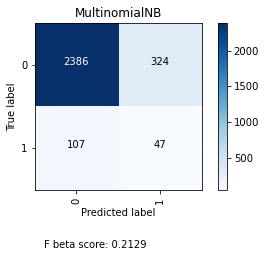

In [35]:
title = 'MultinomialNB'
plot_confusion_matrix([0,1], y_val, y_pred_mnb, title=title, save_path=save_path, save=True)

In [19]:
mnb = NB.MultinomialNB()
submission_mnb = make_submission(mnb, X_all_, y, X_test_all_, test_ds_valid, test_ds_invalid, test_ds)

### Logistic regression

In [20]:
lr = LogisticRegression(class_weight='balanced', max_iter=500)
y_pred_lr = fit_and_predict(lr, X_train_all, y_train, X_val_all, y_val)

Trainning Beta F1 score: 0.2388
Validation Beta F1 score: 0.2392


In [21]:
lr = LogisticRegression(class_weight='balanced', max_iter=500)
submission_lr = make_submission(lr, X_all, y, X_test_all, test_ds_valid, test_ds_invalid, test_ds)

### RandomForest

In [37]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced', random_state=40)
y_pred_rf = fit_and_predict(rf, X_train_num_ohe, y_train, X_val_num_ohe, y_val)

Trainning Beta F1 score: 0.2952
Validation Beta F1 score: 0.2431


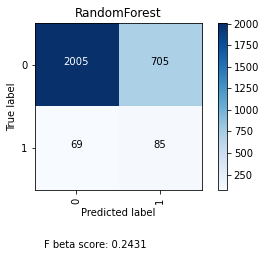

In [38]:
title = 'RandomForest'
plot_confusion_matrix([0,1], y_val, y_pred_rf, title=title, save_path=save_path, save=True)

In [23]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced')
submission_rf = make_submission(rf, X_num_ohe, y, X_test_num_ohe, test_ds_valid, test_ds_invalid, test_ds)

### SVC

In [39]:
svc = SVC(C=1e-1, class_weight='balanced')
y_pred_svc = fit_and_predict(svc, X_train_num_ohe, y_train, X_val_num_ohe, y_val)

Trainning Beta F1 score: 0.3065
Validation Beta F1 score: 0.2655


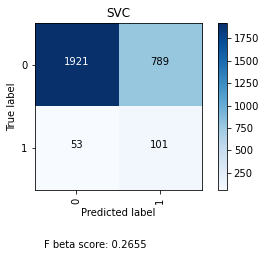

In [40]:
title = 'SVC'
plot_confusion_matrix([0,1], y_val, y_pred_svc, title=title, save_path=save_path, save=True)

In [25]:
svc = SVC(C=1e-1, class_weight='balanced')
submission_svc = make_submission(svc, X_num_ohe, y, X_test_num_ohe, test_ds_valid, test_ds_invalid, test_ds)

In [202]:
submission_svc.to_csv('./submission/submission_svc.csv', index=False)

### XGB

In [41]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, scale_pos_weight=99)
y_pred_xgb = fit_and_predict(xgb, X_train_all, y_train, X_val_all, y_val)

C:\Users\acer\.conda\envs\tiles\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:49] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Trainning Beta F1 score: 0.4972
Validation Beta F1 score: 0.2439


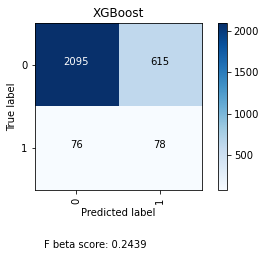

In [42]:
title = 'XGBoost'
plot_confusion_matrix([0,1], y_val, y_pred_xgb, title=title, save_path=save_path, save=True)

In [27]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, scale_pos_weight=99)
submission_xgb = make_submission(xgb, X_all, y, X_test_all, test_ds_valid, test_ds_invalid, test_ds)

[11:50:23] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [43]:
clf_results = pd.DataFrame(val_ds.PerNo)
clf_results['mnb'] = y_pred_mnb
#clf_results['lr'] = y_pred_lr
clf_results['rf'] = y_pred_rf
clf_results['svc'] = y_pred_svc
clf_results['xgb'] = y_pred_xgb
#clf_results['mlp'] = y_pred_mlp

In [44]:
vote_result = voter(clf_results, [1,1,1,1])
y_pred = vote_result.PerStatus.values
F_beta_score(y_val, y_pred)

0.2785176606832657

In [ ]:
title = 'Voting'
plot_confusion_matrix([0,1], y_val, y_pred_mnb, title=title, save_path=save_path, save=True)

In [172]:
submission_mlp2 = pd.read_csv('./submission/submission_mlp2.csv')
submission_mlp3 = pd.read_csv('./submission/submission_mlp3.csv')

In [30]:
submission = pd.DataFrame(submission_mnb.PerNo)
submission['mnb'] = submission_mnb['PerStatus']
#submission['lr'] = submission_lr['PerStatus']
submission['rf'] = submission_rf['PerStatus']
submission['svc'] = submission_svc['PerStatus']
submission['xgb'] = submission_xgb['PerStatus']
#submission['mlp'] = submission_mlp['PerStatus']
#submission['mlp2'] = submission_mlp2['PerStatus']
#submission['mlp3'] = submission_mlp3['PerStatus']
submission

,PerNo,mnb,rf,svc,xgb
0,1,0,0,0,0
1,3,0,0,0,0
2,7,1,1,1,1
3,15,0,0,0,0
4,16,1,0,1,0
...,...,...,...,...,...
3734,8761,0,1,1,1
3735,8765,0,0,0,0
3736,8767,0,1,1,0
3737,8774,0,0,0,0


In [31]:
submission = voter(submission, [1,1,1,1])
submission

,PerNo,PerStatus
0,1,0
1,3,0
2,7,1
3,15,0
4,16,0
...,...,...
3734,8761,1
3735,8765,0
3736,8767,0
3737,8774,0


In [32]:
submission.to_csv('./submission/voter[1 1 1 1]_v3_mnb_rf_svc_xgb.csv', index=False)

In [193]:
F_beta_score(submission_svc['PerStatus'], submission_mlp['PerStatus'])

0.6650721582617155